In [6]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import optuna
import matplotlib.pyplot as plt

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


In [26]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e8/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e8/test.csv')
sub_df = pd.read_csv('/kaggle/input/playground-series-s5e8/sample_submission.csv')

In [5]:
#train_df.to_csv("/kaggle/working/train_df.csv", index=False)

In [ ]:
# we can create separate column with flag for -1 value
train_df['no_previous_contact'] = (train_df['pdays'] == -1).astype(int)
test_df['no_previous_contact'] = (test_df['pdays'] == -1).astype(int)

# We can create additional column with pdays only without -1 values
train_df['pdays_cleaned'] = train_df['pdays'].where(train_df['pdays'] != -1, np.nan) 
test_df['pdays_cleaned'] = test_df['pdays'].where(test_df['pdays'] != -1, np.nan) 

# We can create additional column with numeric months
train_df['month_as_num'] = train_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})
test_df['month_as_num'] = test_df['month'].map({'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11, 'dec':12})

###  feature ='previous'  - Drift with test data

## Feature Engineering - all possible

In [ ]:
def stability(x):
    if x=='management' or x=='technician' or x=='admin.' or x=='services':
        return 0
    elif x=='blue-collar' or x=='self-employed' or x=='entrepreneur':
        return 1
    else:
        return 2

train_df['job_stability'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #High
    if x=='management' or x=='entrepreneur' or x=='self-employed':
        return 0
    # Middle
    elif x=='technician' or x=='admin.' or x=='services':
        return 1
    # Low
    elif x=='blue-collar' or x=='housemaid':
        return 2
    # No earnings
    else:
        return 3

train_df['job_earnings'] = train_df['job'].apply(stability)

In [ ]:
def stability(x):
    #Not working
    if x=='retired' or x=='student' or x=='unemployed' or x=='unknown': 
        return 0
    # working
    else:
        return 1

train_df['job_is_working'] = train_df['job'].apply(stability)

In [ ]:
train_df['prev_success']=(train_df['poutcome'] == 'success').astype(int)

In [ ]:
train_df['duration_mult_age'] = train_df['duration'] * train_df['age']

In [ ]:
train_df['job_and_education'] = train_df['education'] + " " + train_df['job']

In [ ]:
train_df['contact_plus_poutcome'] = train_df['contact'] + ' ' + train_df['poutcome']

In [ ]:
def stability(x):
    if x < 30: 
        return 0
    elif x >= 30 and x <= 60:
        return 1
    else:
        return 2

train_df['age_group'] = train_df['age'].apply(stability)

In [ ]:
def month(x):
    if x < 5:
        return 0
    elif x >= 5 and x <=8:
        return 1
    else:
        return 2 

train_df['month_group'] = train_df['month_as_num'].apply(month)

In [ ]:
def duration(x):
    # short
    if x < 120:
        return 0
    # medium
    elif x >= 120 and x <=250:
        return 1
    # long
    else:
        return 2

train_df['duration_long'] = train_df['duration'].apply(duration)

In [ ]:
mapping = ({'yes':1,"no":0})
train_df['loan_code'] = train_df['loan'].map(mapping)
train_df['housing_code'] = train_df['housing'].map(mapping)

train_df['loan_plus_housing'] = (train_df['loan_code']+train_df['housing_code']).astype(int)

In [ ]:
train_df['deep_debt'] = ((train_df['balance'] < 0 ) & (train_df['loan_plus_housing'] == 2)).astype(int)

## ML Experiments 

In [8]:
train_df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y'],
      dtype='object')

In [27]:


# ==== WPROWADŹ SWOJE KOLUMNY ====
categorical_cols = [ 'job', 'marital','education','default','housing','loan','contact','month','poutcome']  # <- wpisz swoje kolumny kategoryczne
numerical_cols = ['age','balance', 'day', 'duration', 'campaign','pdays']#, 'previous']    # <- wpisz swoje kolumny numeryczne
target_col = 'y'



In [28]:
# ==== WCZYTAJ DANE ====
# train_df i test_df muszą być wcześniej wczytane

df = train_df.copy()
X = df[categorical_cols + numerical_cols].copy()
y = df[target_col].copy()

# ==== ENKODOWANIE DANYCH KATEGORYCZNYCH ==== Dla CATBOOSTA MOŻNA POMINĄ TYLKO PODAĆ LISTĘ
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# ==== K-FOLD USTAWIENIA ====
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==== FUNKCJA TRENOWANIA MODELU ====
def train_model(X, y, params):
    scores = []
    importances = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            eval_metric='auc',
            use_label_encoder=False,
            n_jobs=-1,
            scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
        )
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        importances.append(model.feature_importances_)

        print(f"Fold {fold+1} ROC-AUC: {auc:.5f}")

    print(f"\nŚredni ROC-AUC: {np.mean(scores):.5f}")
    avg_importances = np.mean(importances, axis=0)

    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': avg_importances
    }).sort_values(by='importance', ascending=False)

    print("\nFeature Importances:\n", importance_df)

    # Można też narysować
    importance_df.plot.bar(x='feature', y='importance', legend=False,  figsize=(10,5))
    plt.title("Średnia ważność cech (feature importance)")
    plt.show()

Fold 1 ROC-AUC: 0.96586
Fold 2 ROC-AUC: 0.96479
Fold 3 ROC-AUC: 0.96469
Fold 4 ROC-AUC: 0.96613
Fold 5 ROC-AUC: 0.96524

Średni ROC-AUC: 0.96534

Feature Importances:
       feature  importance
12   duration    0.309957
6     contact    0.190103
4     housing    0.127965
8    poutcome    0.062122
5        loan    0.058584
7       month    0.053221
14      pdays    0.048895
2   education    0.026932
1     marital    0.022409
10    balance    0.021547
11        day    0.018334
13   campaign    0.018019
9         age    0.015530
0         job    0.014118
15   previous    0.007749
3     default    0.004515


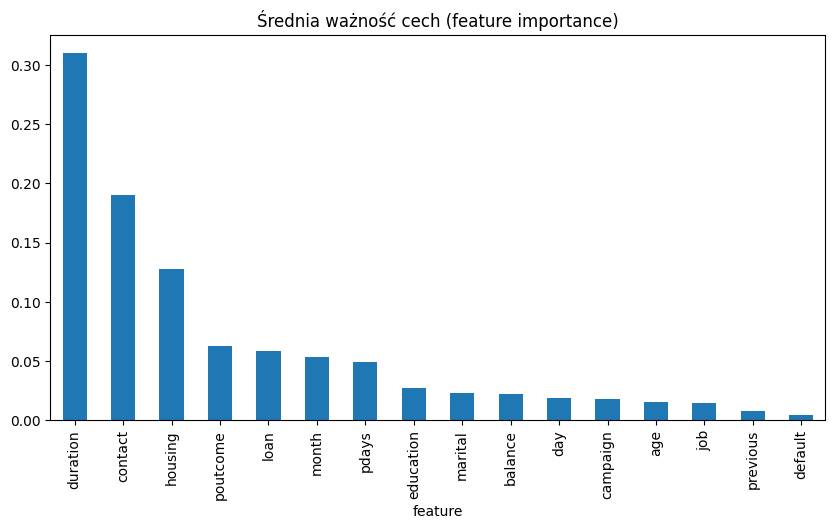

In [17]:
params = {'learning_rate':0.2}
train_model(X, y, params)

In [20]:
# ==== OPCJA 1: GRID SEARCH ====
def grid_search():
    param_grid = {
        'max_depth': [3],#, 5],
        'learning_rate': [0.1],#, 0.05],
        'n_estimators': [100, 200],
        'subsample': [0.8]#, 1.0]
    }

    best_score = -np.inf
    best_params = None

    from itertools import product

    keys, values = zip(*param_grid.items())
    for combination in product(*values):
        params = dict(zip(keys, combination))
        print("\nSprawdzam parametry:", params)
        try:
            train_model(X, y, params)
            # Jeżeli chcesz, dodaj kod do zapisu najlepszego modelu tutaj
        except Exception as e:
            print("Błąd:", e)


Sprawdzam parametry: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.8}
Fold 1 ROC-AUC: 0.95441
Fold 2 ROC-AUC: 0.95431
Fold 3 ROC-AUC: 0.95395
Fold 4 ROC-AUC: 0.95547
Fold 5 ROC-AUC: 0.95439

Średni ROC-AUC: 0.95451

Feature Importances:
       feature  importance
12   duration    0.304341
4     housing    0.116512
6     contact    0.112767
8    poutcome    0.087203
14      pdays    0.054233
10    balance    0.050340
1     marital    0.046762
5        loan    0.043322
2   education    0.042180
7       month    0.034599
13   campaign    0.032076
0         job    0.027774
9         age    0.025931
11        day    0.017284
15   previous    0.004675
3     default    0.000000


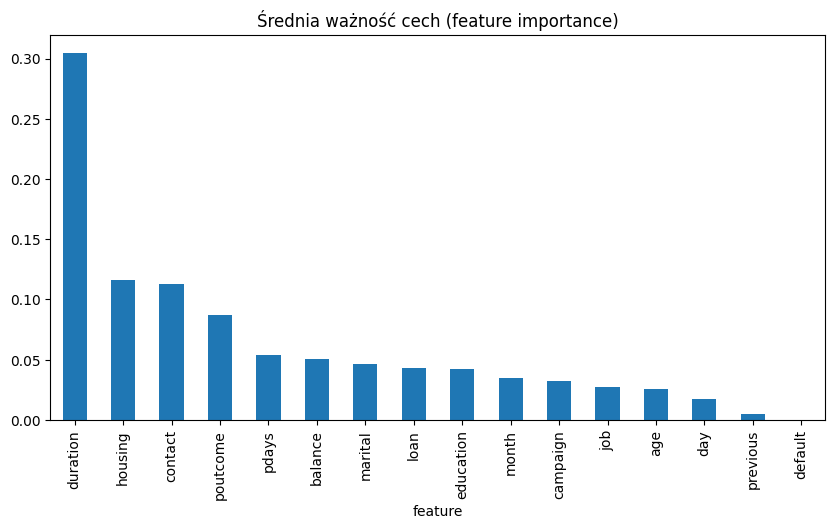


Sprawdzam parametry: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 200, 'subsample': 0.8}
Fold 1 ROC-AUC: 0.95971
Fold 2 ROC-AUC: 0.95895
Fold 3 ROC-AUC: 0.95876
Fold 4 ROC-AUC: 0.95972
Fold 5 ROC-AUC: 0.95885

Średni ROC-AUC: 0.95920

Feature Importances:
       feature  importance
12   duration    0.288499
4     housing    0.155275
6     contact    0.123459
8    poutcome    0.072658
14      pdays    0.054424
5        loan    0.053936
1     marital    0.049504
2   education    0.037766
10    balance    0.036880
7       month    0.032286
13   campaign    0.027646
9         age    0.027461
0         job    0.019388
11        day    0.016087
15   previous    0.003771
3     default    0.000961


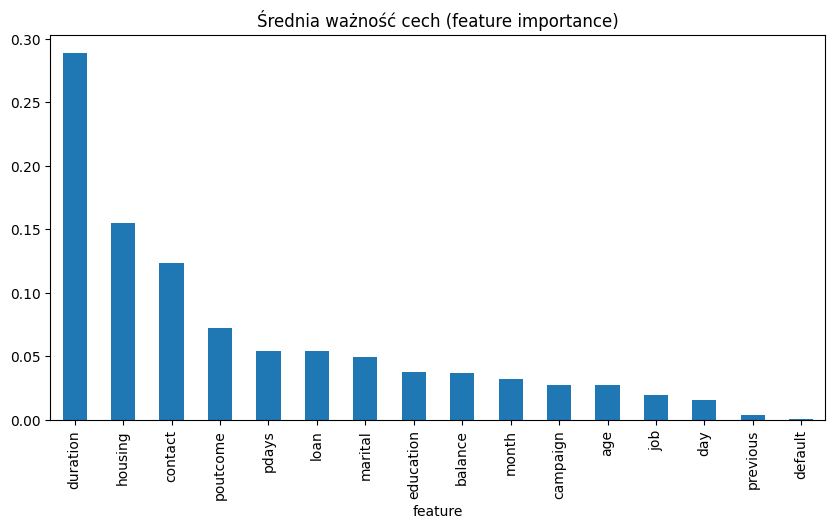

In [21]:
grid_search()

In [30]:
def optuna_search(n_trials=30):
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
        }

        scores = []
        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

            model = XGBClassifier(
                **params,
                eval_metric='auc',
                use_label_encoder=False,
                n_jobs=-1,
                scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
            )

            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            scores.append(auc)

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\nNajlepsze parametry Optuna:\n", study.best_params)
    print(f"Najlepszy ROC-AUC: {study.best_value:.5f}")

    # Trenowanie najlepszego modelu na koniec
    train_model(X, y, study.best_params)

[I 2025-08-04 14:48:46,660] A new study created in memory with name: no-name-ef504507-10fb-4c08-b62c-d70f4dc7f5c6
[I 2025-08-04 14:49:17,691] Trial 0 finished with value: 0.9634913695374528 and parameters: {'max_depth': 3, 'learning_rate': 0.19672721028906862, 'n_estimators': 306, 'subsample': 0.7532641996557451, 'colsample_bytree': 0.723078912613888, 'gamma': 1.4986364316451168, 'reg_alpha': 0.4715242334766018, 'reg_lambda': 0.5157542292720457}. Best is trial 0 with value: 0.9634913695374528.
[I 2025-08-04 14:49:43,158] Trial 1 finished with value: 0.9593306987183485 and parameters: {'max_depth': 3, 'learning_rate': 0.0912543062274461, 'n_estimators': 230, 'subsample': 0.6303889571210712, 'colsample_bytree': 0.7199520217277173, 'gamma': 4.945847415648434, 'reg_alpha': 3.321782001240913, 'reg_lambda': 3.928427502517209}. Best is trial 0 with value: 0.9634913695374528.
[I 2025-08-04 14:50:12,848] Trial 2 finished with value: 0.9599778041275853 and parameters: {'max_depth': 3, 'learning_


Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96860
Fold 2 ROC-AUC: 0.96714
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96854
Fold 5 ROC-AUC: 0.96785

Średni ROC-AUC: 0.96787

Feature Importances:
       feature  importance
12   duration    0.361053
6     contact    0.166310
4     housing    0.132702
8    poutcome    0.083217
7       month    0.062788
5        loan    0.041027
14      pdays    0.026778
10    balance    0.024013
11        day    0.019122
2   education    0.016243
13   campaign    0.016015
1     marital    0.015528
9         age    0.015053
0         job    0.011771
3     default    0.008379


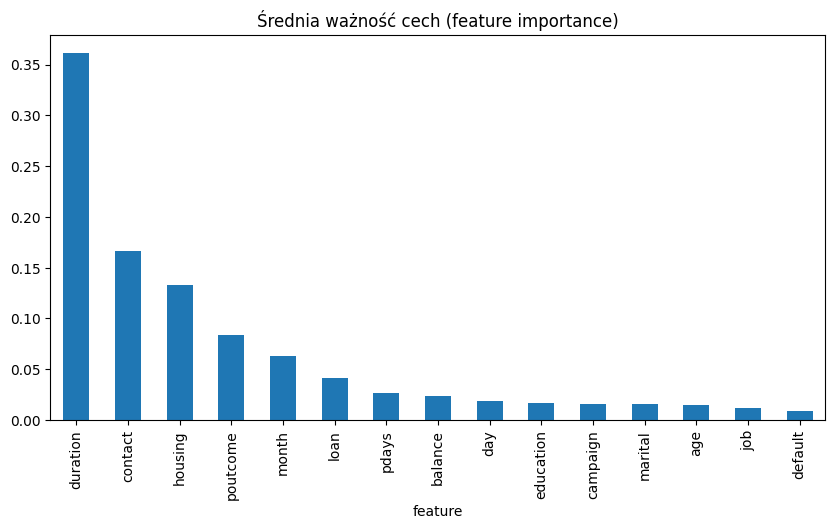

In [31]:
optuna_search(n_trials=30)

In [ ]:
# RAW DATA  With optuna XGBoost
Najlepsze parametry Optuna:
 {'max_depth': 10, 'learning_rate': 0.088542375425159, 'n_estimators': 353, 'subsample': 0.7933680125492807, 'colsample_bytree': 0.665859932215261, 'gamma': 1.9591038948726576, 'reg_alpha': 4.135658777432998, 'reg_lambda': 3.0378978111339086}
Najlepszy ROC-AUC: 0.96788
Fold 1 ROC-AUC: 0.96859
Fold 2 ROC-AUC: 0.96726
Fold 3 ROC-AUC: 0.96728
Fold 4 ROC-AUC: 0.96853
Fold 5 ROC-AUC: 0.96773

Średni ROC-AUC: 0.96788

Feature Importances:
       feature  importance
12   duration    0.255548
6     contact    0.171966
4     housing    0.160483
8    poutcome    0.070366
7       month    0.061991
14      pdays    0.056551
5        loan    0.044870
10    balance    0.037885
11        day    0.022941
1     marital    0.022816
13   campaign    0.021023
9         age    0.017168
2   education    0.016198
0         job    0.015291
15   previous    0.013801
3     default    0.011103

In [ ]:
# RAW DATA  With optuna XGBoost bez cechy previous 
Najlepsze parametry Optuna:
 {'max_depth': 9, 'learning_rate': 0.11410300715659989, 'n_estimators': 368, 'subsample': 0.907977121199552, 'colsample_bytree': 0.6014268962223818, 'gamma': 0.7012459904827175, 'reg_alpha': 4.361523501536162, 'reg_lambda': 4.294305690785547}
Najlepszy ROC-AUC: 0.96787
Fold 1 ROC-AUC: 0.96860
Fold 2 ROC-AUC: 0.96714
Fold 3 ROC-AUC: 0.96721
Fold 4 ROC-AUC: 0.96854
Fold 5 ROC-AUC: 0.96785

Średni ROC-AUC: 0.96787

Feature Importances:
       feature  importance
12   duration    0.361053
6     contact    0.166310
4     housing    0.132702
8    poutcome    0.083217
7       month    0.062788
5        loan    0.041027
14      pdays    0.026778
10    balance    0.024013
11        day    0.019122
2   education    0.016243
13   campaign    0.016015
1     marital    0.015528
9         age    0.015053
0         job    0.011771
3     default    0.008379